# 贝叶斯判别准则族

## 基本原理

统计学似然比准则
$$
    \left\{
    \begin{array}{ll}
    x \in G_1 &, \frac{f_1(x)}{f_2(x)} \ge \frac{L(1|2)p_{2}}{L(2|1)p_{1}} \\
    x \in G_2 &, \frac{f_1(x)}{f_2(x)} < \frac{L(1|2)p_{2}}{L(2|1)p_{1}} 
    \end{array}
    \right. 
$$
\* 其中$p_{1}$、$p_{2}$是两个分布的先验概率，一般可以使用样本数量进行近似，即
$$
    \left\{
    \begin{array}
    p_{1} = \frac{n_{1}}{n_{1}+n_{2}} \\
    p_{2} = \frac{n_{2}}{n_{1}+n_{2}}
    \end{array}
    \right.
$$
\* 而$L(1|2)$、$L(2|1)$是分类的损失，一般情况下选取为1

一般我们认为总体服从多元$x \in R^{p}$正态分布，意即
$$
    f_{i}(x) = (2\pi)^{-\frac{p}{2}}|\Sigma^{-\frac{1}{2}}|exp\{-\frac{1}{2}{(x-\mu_{i})}^T\Sigma^{-1}(x-\mu_{i})\}
$$
设总体$X_i ~ N_p(\mu_i,\Sigma_i), i=1,2$
那么对于两个整体$G_1,G_2$而言，
$$
    \left\{
    \begin{array}{ll}
    R_1 = \{x: W(x) \ge \beta\} \\
    R_2 = \{x: W(x) < \beta\}
    \end{array}
    \right.
$$
1. 两整体协方差矩阵相同$\Sigma_1=\Sigma_2=\Sigma$
$$
     W(x)=[x-\frac{1}{2}(\mu_1+\mu_2)]^T\Sigma^{-1}(\mu_1-\mu_2) \\
     \beta = ln\frac{L(1|2)\cdot p_2}{L(2|1)\cdot p_1}
$$
2. 两整体协方差矩阵不相同$\Sigma_1 \ne \Sigma_2$
$$
    W(x)=-\frac{1}{2}x^T(\Sigma_{1}^{-1}-\Sigma_{2}^{-1})x+(\mu_1^T\Sigma_{1}^{-1}-\mu_2^T\Sigma_{2}^{-1})x \\
    \beta = ln\frac{L(1|2)\cdot p_2}{L(2|1)\cdot p_1} + \frac{1}{2}ln\frac{|\Sigma_1|}{|\Sigma_2|}+\frac{1}{2}(\mu_1^T\Sigma_{1}^{-1}\mu_1 - \mu_2^T\Sigma_{2}^{-1}\mu_2)
$$

## Mahalonobis Distance

## 定义
$$
    d^{2}(\vec x, G) = (\vec x - \mu)^{T}\Sigma^{-1} (\vec x - \mu)
$$
\* 其中，$\Sigma$是协方差矩阵，$\mu$是分布的期望

## 作用
1. 区分离群值
2. 基于线性相关属性进行准确分类
3. 本质上是对数据进行标准化预处理

In [1]:
import pandas as pd
import scipy as sp
import numpy as np

filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/diamonds.csv'
df = pd.read_csv(filepath).iloc[:, [0,4,6]]
df.head()

,carat,depth,price
0,0.23,61.5,326
1,0.21,59.8,326
2,0.23,56.9,327
3,0.29,62.4,334
4,0.31,63.3,335


In [2]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return np.diagonal(mahal)

df_x = df[['carat', 'depth', 'price']].head(500)
data = df[['carat', 'depth', 'price']]
df_x['mahala'] = mahalanobis(x=df_x, data=data)
df_x.head()


,carat,depth,price,mahala
0,0.23,61.5,326,1.709860
1,0.21,59.8,326,3.540097
2,0.23,56.9,327,12.715021
3,0.29,62.4,334,1.454469
4,0.31,63.3,335,2.347239


# 多元异常值检测

## 置信区间假设检验
假设检验的置信区间$\alpha=0.01$

In [36]:
from scipy.stats import chi2

alpha = chi2.ppf((1-0.01),df=2)
df_trimmed_1 = df_x[(df_x['mahala']>alpha)]
df_trimmed_1.head(10)

,carat,depth,price,mahala,p_value
2,0.23,56.9,327,12.715021,0.001734
91,0.86,55.1,2757,23.909643,0.000006
97,0.96,66.3,2759,11.781773,0.002765
172,1.17,60.2,2774,9.279459,0.009660
204,0.98,67.9,2777,20.086616,0.000043
221,0.70,57.2,2782,10.405659,0.005501
227,0.84,55.1,2782,23.548379,0.000008
255,1.05,65.8,2789,11.237146,0.003630
284,1.00,58.2,2795,10.349019,0.005659
298,1.01,67.4,2797,17.716144,0.000142


## 显著性水平假设检验
接下来使用显著性水平$p$

In [34]:
df_x['p_value'] = 1 - chi2.cdf(df_x['mahala'],df=2)
df_x.loc[df_x.p_value < 0.01].head(10)

,carat,depth,price,mahala,p_value
2,0.23,56.9,327,12.715021,0.001734
91,0.86,55.1,2757,23.909643,0.000006
97,0.96,66.3,2759,11.781773,0.002765
172,1.17,60.2,2774,9.279459,0.009660
204,0.98,67.9,2777,20.086616,0.000043
221,0.70,57.2,2782,10.405659,0.005501
227,0.84,55.1,2782,23.548379,0.000008
255,1.05,65.8,2789,11.237146,0.003630
284,1.00,58.2,2795,10.349019,0.005659
298,1.01,67.4,2797,17.716144,0.000142


# 二分类问题


In [40]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BreastCancer.csv', 
                 usecols=['Cl.thickness', 'Cell.size', 'Marg.adhesion', 
                          'Epith.c.size', 'Bare.nuclei', 'Bl.cromatin', 'Normal.nucleoli', 
                          'Mitoses', 'Class'])

df.dropna(inplace=True)  # drop missing values.
df.head()

,Cl.thickness,Cell.size,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,5,1,1,2,1.0,3,1,1,0
1,5,4,5,7,10.0,3,2,1,0
2,3,1,1,2,2.0,3,1,1,0
3,6,8,1,3,4.0,3,7,1,0
4,4,1,3,2,1.0,3,1,1,0


In [42]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('Class',axis=1),
                                                    df['Class'],test_size=0.2,
                                                    random_state=100)
x_train_pos = x_train.loc[y_train == 1, :]
x_test_pos = x_test.loc[y_test == 1, :]

## 构建分类器

In [46]:
class MahalanobisBinaryClassifier():
    def __init__(self, x_train, y_train):
        self.x_train_pos = x_train.loc[y_train==1,:]
        self.x_train_neg = x_train.loc[y_train==0,:]
        
    def predict_proba(self, x_test):
        pos_neg_dists = [(pos,neg) 
                         for pos,neg in zip(mahalanobis(x_test, self.x_train_pos),
                                           mahalanobis(x_test, self.x_train_neg))]
        return np.array([(1-neg/(pos+neg),1-pos/(pos+neg)) for pos,neg in pos_neg_dists])
    
    def predict(self, x_test):
        return np.array([np.argmax(row) for row in self.predict_proba(x_test)])
    

In [47]:
mahal_clf = MahalanobisBinaryClassifier(x_train, y_train)
pred_probas = mahal_clf.predict_proba(x_test)
pred_res = mahal_clf.predict(x_test)

pred_act = pd.DataFrame([(pred, act) for pred,act in zip(pred_res, y_test)],
                        columns=['prediction','actual'])
pred_act.head(10)

,prediction,actual
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,0
8,1,0
9,1,1


## 分类器检测

In [50]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

truth = pred_act.loc[:,'actual']
pred = pred_act.loc[:,'prediction']
scores = np.array(pred_probas)[:,1]
print('AUROC: ', roc_auc_score(truth, scores))
print('\nConfusion Matrix: \n', confusion_matrix(truth, pred))
print('\nAccuracy Score: ', accuracy_score(truth, pred))
print('\nClassification Report: \n', classification_report(truth, pred))

AUROC:  0.9912529550827424

Confusion Matrix: 
 [[76 14]
 [ 0 47]]

Accuracy Score:  0.8978102189781022

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.84      0.92        90
           1       0.77      1.00      0.87        47

    accuracy                           0.90       137
   macro avg       0.89      0.92      0.89       137
weighted avg       0.92      0.90      0.90       137



# 多分类问题

## 构建分类器

# 卡方分布$\chi^2$

## ppf函数
1. ppf函数是cdf函数的逆函数
2. 通过给定cdf一个x值，能够求出该x值出现的概率是多少
    1. 如果是p置信区间进行估计，查看第一类错误区间是否在p置信区间内，若在则接受备择假设
    2. 如果是$\alpha$置信度进行估计，查看查看第一类错误区间是否包含该概率，若不包含在接受备择假设
    3. 以上二者的本质上都是该概率应该在第一类错误区间端点内侧【双边均满足】

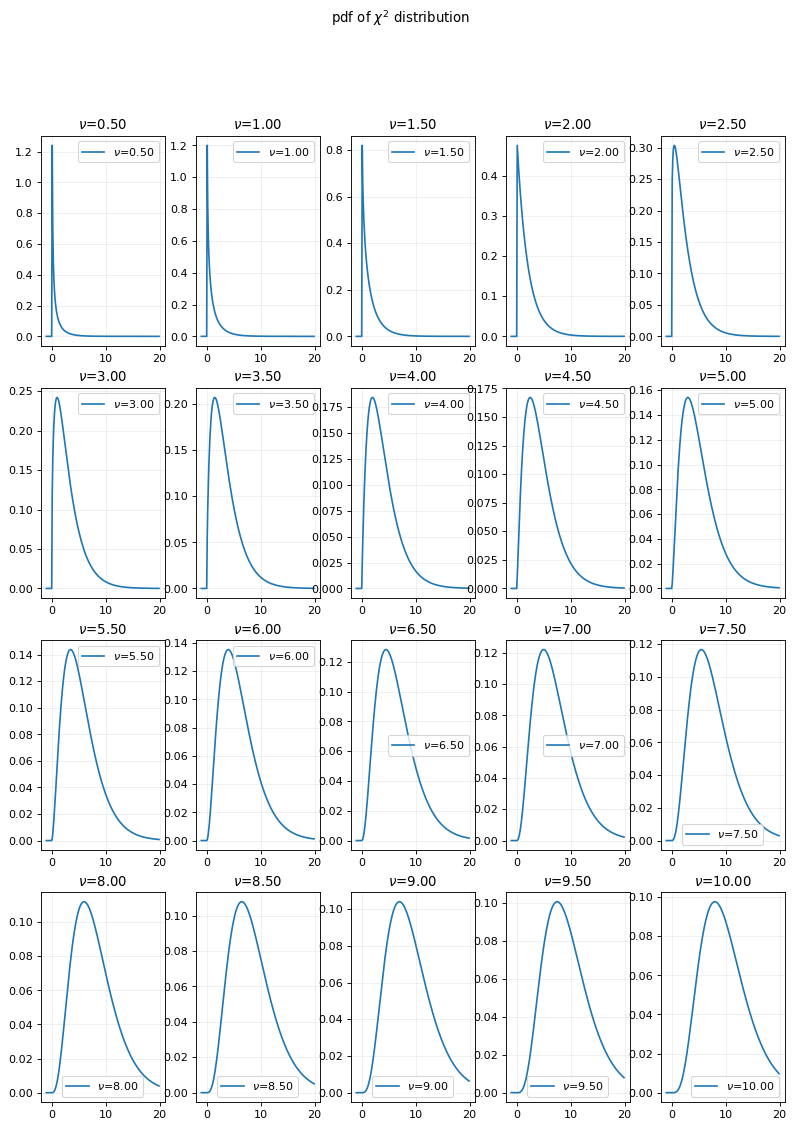

In [19]:
from scipy.stats import chi2
from matplotlib import pyplot as plt
import numpy as np

x = np.arange(-1,20,0.1)
df = np.arange(0.5,10.5,0.5)
fig = plt.figure(figsize=(12,16),dpi=80)
fig.suptitle(r'pdf of $\chi^2$ distribution')
plt.subplots_adjust(hspace=0.2,wspace=0.25)
for i in range(len(df)):
    plt.subplot(4,5,i+1).plot(x, chi2.pdf(x,df[i]),label=r'$\nu$=%.2f'%df[i])
    plt.subplot(4,5,i+1).set_title(r'$\nu$=%.2f'%df[i])
    plt.legend()
    plt.grid(alpha=0.2)

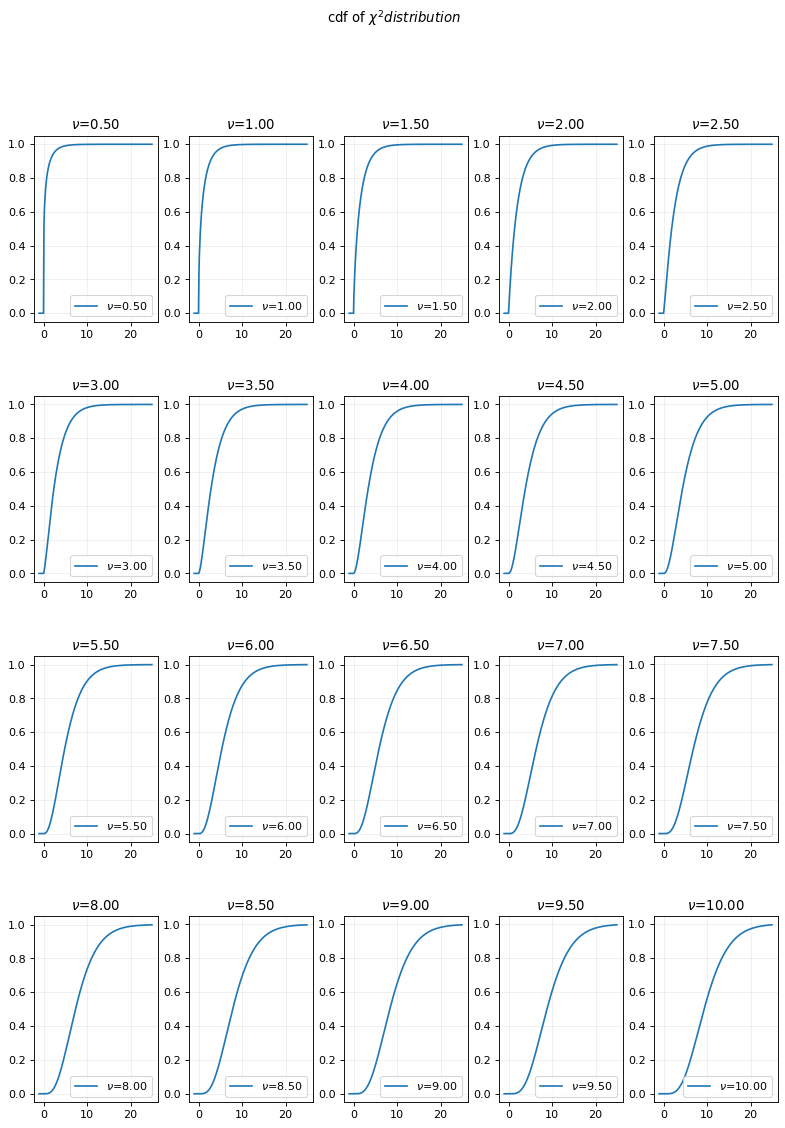

In [22]:
xx = np.arange(-1,25,0.1)

fig = plt.figure(figsize=(12,16),dpi=80)
fig.suptitle(r'cdf of $\chi^2 distribution$')
plt.subplots_adjust(hspace=0.4,wspace=0.25)
for i in range(len(df)):
    plt.subplot(4,5,i+1).plot(xx, chi2.cdf(xx,df[i]),label=r'$\nu$=%.2f'%df[i])
    plt.subplot(4,5,i+1).set_title(r'$\nu$=%.2f'%df[i])
    plt.legend()
    plt.grid(alpha=0.2)

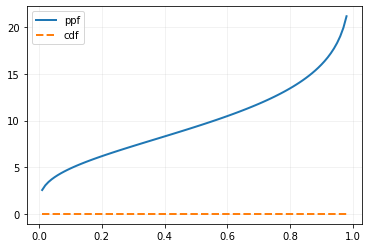

In [38]:
from scipy.stats import chi2
from matplotlib import pyplot as plt
import numpy as np

x_ppf = np.arange(0.01,0.99,0.01)
y_ppf = chi2.ppf(x_ppf, df=10)
y_cdf = chi2.cdf(x_ppf, df=10)
plt.plot(x_ppf,y_ppf,lw=2,ls='-',label='ppf')
plt.plot(x_ppf,y_cdf,lw=2,ls='--',label='cdf')
plt.legend()
plt.grid(alpha=0.2)